# Airbnb
### Imports

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
sns.set_style('darkgrid')
%matplotlib inline

### Q1. Does Airbnb have seasonality to their occupancy?

In [98]:
df = pd.read_csv('airbnb_calendar.csv')
df['date'] = pd.to_datetime(df['date'])
df.info(), df['date'].min(),df['date'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702460 entries, 0 to 2702459
Data columns (total 5 columns):
Unnamed: 0    int64
listing_id    int64
date          datetime64[ns]
City          object
Occupied      int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 103.1+ MB


(None, Timestamp('2016-01-04 00:00:00'), Timestamp('2017-09-05 00:00:00'))

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


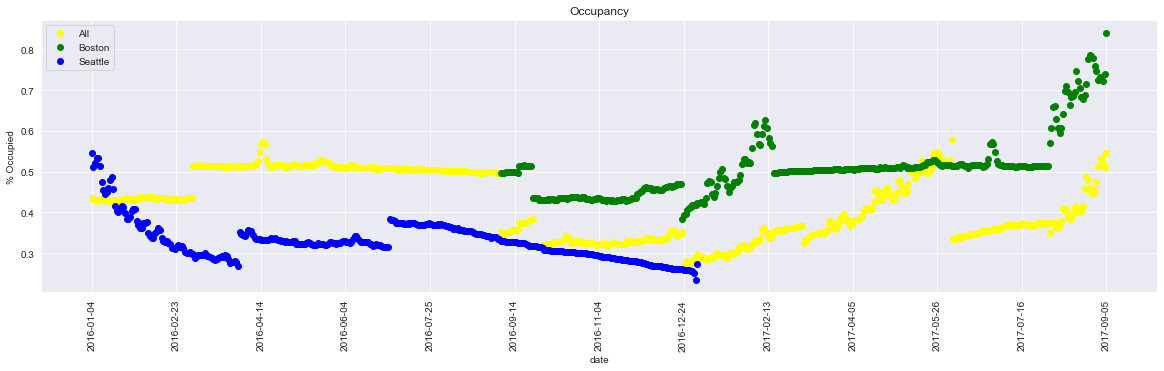

In [99]:
d0 = df['date'].min()
d1 = df['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(df['date'].unique(), df.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(df[df['City']=='Boston']['date'].unique(), df[df['City']=='Boston'].groupby(['date']).mean()['Occupied'], color='green', label='Boston')
plt.plot_date(df[df['City']=='Seattle']['date'].unique(), df[df['City']=='Seattle'].groupby(['date']).mean()['Occupied'], color='blue', label='Seattle')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

Although some seasonality appears to exist, we may want to categorize the listings a little for better insight

In [100]:
dfl = pd.read_csv('airbnb_listings.csv')

In [101]:
dfl.groupby(['property_type', 'room_type']).count()['id']

property_type    room_type      
Apartment        Entire home/apt    3192
                 Private room       1015
                 Shared room         113
Bed & Breakfast  Entire home/apt       5
                 Private room         71
                 Shared room           2
Boat             Entire home/apt      14
                 Private room          6
Bungalow         Entire home/apt      12
                 Private room          1
Cabin            Entire home/apt      16
                 Private room          5
Camper/RV        Entire home/apt      10
                 Private room          3
                 Shared room           1
Chalet           Entire home/apt       1
                 Private room          1
Condominium      Entire home/apt     222
                 Private room         97
                 Shared room           3
Dorm             Private room          2
                 Shared room           2
Entire Floor     Entire home/apt       2
                 Private

For the purposes of this investigation, we will focus on completely stationary rentals (no RVs, tents, etc)

In [102]:
dfs = dfl[dfl['property_type'].isin(['Apartment', 'Bed & Breakfast','Bungalow','Cabin','Chalet','Condominium','Dorm','Entire Floor','Guesthouse','House','Loft','Townhouse','Treehouse','Villa'])].copy()
dfs['beds'].fillna(1, inplace=True)
dfs['bathrooms'].fillna(1, inplace=True)
dfs['security_deposit'].fillna(0, inplace=True)
dfs['cleaning_fee'].fillna(0, inplace=True)
dfs.rename(columns={"id": "listing_id"}, inplace=True)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7320 entries, 0 to 7402
Data columns (total 36 columns):
Unnamed: 0                          7320 non-null int64
listing_id                          7320 non-null int64
host_response_rate                  6342 non-null object
host_acceptance_rate                6097 non-null object
host_is_superhost                   7318 non-null object
host_listings_count                 7318 non-null float64
neighbourhood_cleansed              7320 non-null object
latitude                            7320 non-null float64
longitude                           7320 non-null float64
property_type                       7320 non-null object
room_type                           7320 non-null object
accommodates                        7320 non-null int64
bathrooms                           7320 non-null float64
beds                                7320 non-null float64
bed_type                            7320 non-null object
price                               

In [103]:
#Next steps: Inner join to calendar to run availability by room type and/or property type
dfj = dfs[['listing_id','property_type','room_type','accommodates','bathrooms','beds','bed_type','price', 'security_deposit', 'cleaning_fee']]
dfj = dfj.join(df.set_index('listing_id'), on='listing_id', lsuffix='_ids', rsuffix='_calendar')
dfj.head(), dfj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2672165 entries, 0 to 7402
Data columns (total 14 columns):
listing_id          int64
property_type       object
room_type           object
accommodates        int64
bathrooms           float64
beds                float64
bed_type            object
price               float64
security_deposit    float64
cleaning_fee        float64
Unnamed: 0          int64
date                datetime64[ns]
City                object
Occupied            int64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 305.8+ MB


(   listing_id property_type        room_type  accommodates  bathrooms  beds  \
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 
    bed_type  price  security_deposit  cleaning_fee  Unnamed: 0       date  \
 0  Real Bed  250.0               0.0          35.0           0 2017-09-05   
 0  Real Bed  250.0               0.0          35.0           1 2017-09-04   
 0  Real Bed  250.0               0.0          35.0           2 2017-09-03   
 0  Real Bed  250.0               0.0          35.0           3 2017-09-02   
 0  Real Bed  250.0               0.0          35.0           4 2017-09-01   
 
      City  Occupied  
 0  Boston         1  
 0

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


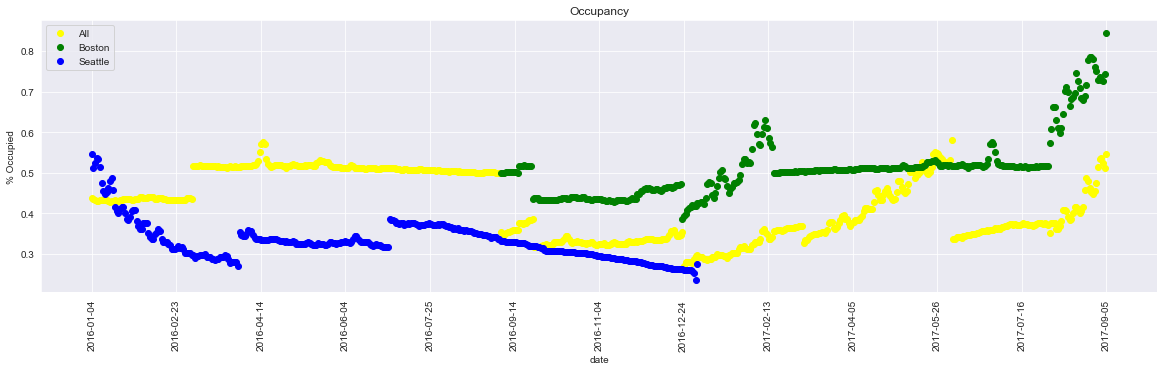

In [104]:
# Generate an availability graph using only stationary properties
d0 = dfj['date'].min()
d1 = dfj['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(dfj['date'].unique(), dfj.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(dfj[dfj['City']=='Boston']['date'].unique(), dfj[dfj['City']=='Boston'].groupby(['date']).mean()['Occupied'], color='green', label='Boston')
plt.plot_date(dfj[dfj['City']=='Seattle']['date'].unique(), dfj[dfj['City']=='Seattle'].groupby(['date']).mean()['Occupied'], color='blue', label='Seattle')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

Removing the mobile type rentals didn't drastically alter our availability graph, which does show some seasonality. <br>
Overall, there is a busy season ramping up from early february until september, with small periods inbetween of fluxuating availability

### Does rental property type influence room pricing?

In [105]:
dfs['room_type'].value_counts()

Entire home/apt    4623
Private room       2508
Shared room         189
Name: room_type, dtype: int64

With only 189 shared rooms in our sample, we will focus on the "Entire home/apt" and "Private room"

In [106]:
dfp = dfs[dfs['room_type']=='Private room'].groupby(['property_type']).mean()['price'].copy()
dfp.nlargest(13)

property_type
Villa              152.500000
Bed & Breakfast    123.971831
Condominium        105.134021
Loft               100.647059
Apartment           94.184236
Entire Floor        90.000000
Townhouse           86.735294
House               74.551724
Cabin               74.400000
Bungalow            70.000000
Dorm                62.500000
Chalet              62.000000
Treehouse           51.500000
Name: price, dtype: float64

In [107]:
dfp = dfs[dfs['room_type']=='Entire home/apt'].groupby(['property_type']).mean()['price'].copy()
dfp.nlargest(13)

property_type
Guesthouse         289.000000
Villa              263.500000
Condominium        212.995495
Townhouse          211.823529
House              203.231286
Treehouse          200.000000
Loft               182.322034
Apartment          182.237469
Entire Floor       154.000000
Chalet             135.000000
Bungalow           119.416667
Bed & Breakfast    114.800000
Cabin              114.125000
Name: price, dtype: float64

There is a significant difference in the mean price of room rentals based on the property type. This is more understandable when you are renting the entire property vs. a private room

In [108]:
dfs.groupby(['property_type', 'room_type']).std()['price']

property_type    room_type      
Apartment        Entire home/apt    133.750634
                 Private room        93.095212
                 Shared room         73.951737
Bed & Breakfast  Entire home/apt     31.348046
                 Private room        70.641342
                 Shared room          9.899495
Bungalow         Entire home/apt     77.256901
                 Private room              NaN
Cabin            Entire home/apt     58.503419
                 Private room        30.121421
Chalet           Entire home/apt           NaN
                 Private room              NaN
Condominium      Entire home/apt    127.468513
                 Private room        49.408507
                 Shared room         19.218047
Dorm             Private room        17.677670
                 Shared room          2.121320
Entire Floor     Entire home/apt      1.414214
                 Private room        14.142136
Guesthouse       Entire home/apt           NaN
House            Entire hom

There is also a great deal of price deviation per property type. Further analysis would need to be done to see the relative impact of property type

In [109]:
def create_dummy_df(df, cat_cols, dummy_na, drop_first):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=drop_first, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [118]:
#Next steps - Linear regression for price
#Setup dummy variables
ccols = ('property_type', 'room_type', 'bed_type', 'instant_bookable', 'host_is_superhost','cancellation_policy','require_guest_phone_verification','require_guest_profile_picture','requires_license')
dfl = create_dummy_df(dfs, ccols, True, False)

# Drop Intercept parameters, then uneeded columns
dfl.drop(['requires_license_f','require_guest_phone_verification_f','require_guest_phone_verification_t','property_type_Apartment','room_type_Entire home/apt','bed_type_Real Bed','instant_bookable_f', 'host_is_superhost_t','cancellation_policy_nan'], axis=1, inplace=True)
dfl.drop(['Unnamed: 0', 'listing_id', 'host_response_rate', 'host_acceptance_rate', 'neighbourhood_cleansed','latitude','longitude'], axis=1, inplace=True)
dfl.drop(['require_guest_profile_picture_f','reviews_per_month','number_of_reviews','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication','review_scores_location','review_scores_value'], axis=1, inplace=True)
dfl.dropna(inplace=True) #drop the two records missing host_listings_count

#Split into explanatory and response variables
X = dfl.drop(['price'], axis=1)
y = dfl['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was -106396019.06923221 on 2196 values.'

In [119]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


coef_df = coef_weights(lm_model.coef_, X_train)

#look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
39,cancellation_policy_super_strict_30,2.286047e+12,2.286047e+12
36,cancellation_policy_flexible,2.286047e+12,2.286047e+12
38,cancellation_policy_strict,2.286047e+12,2.286047e+12
37,cancellation_policy_moderate,2.286047e+12,2.286047e+12
17,property_type_Guesthouse,7.239245e+07,7.239245e+07
25,room_type_Shared room,-6.046921e+01,6.046921e+01
15,property_type_Dorm,-5.997166e+01,5.997166e+01
22,property_type_Villa,5.362866e+01,5.362866e+01
11,property_type_Bungalow,-5.118401e+01,5.118401e+01
2,bathrooms,4.332939e+01,4.332939e+01


Cancelllation policy, property type, # of bathrooms, and room types appear to have the most influence on pricing

### Does having a cleaning fee or security deposit affect your occupancy?

In [ ]:
# Generate an availability graph using only stationary properties
d0 = dfj['date'].min()
d1 = dfj['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(dfj['date'].unique(), dfj.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(dfj[dfj['cleaning_fee']!=0]['date'].unique(), dfj[dfj['cleaning_fee']!=0].groupby(['date']).mean()['Occupied'], color='purple', label='With cleaning fee')
plt.plot_date(dfj[dfj['security_deposit']!=0]['date'].unique(), dfj[dfj['security_deposit']!=0].groupby(['date']).mean()['Occupied'], color='red', label='With security deposit')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

There is some odd High availability season trending where a security deposit is correlated with a greater occupancy rate, lets take a look at the room type distribution concerning security deposits

In [ ]:
dfs['has_security_deposit'] = np.where(dfs['security_deposit']>0, 1, 0)

In [ ]:
dfs.groupby(['property_type', 'room_type']).mean()['has_security_deposit']